In [1]:
import math
import numpy as np
import pickle
import neat
import torch
from plot_util import *
from data_load_util import *
from projections_util import *
from Neat.evaluation_util import *
from Neat.saving_util import *

In [2]:
combined_df = make_dataset(remove_outliers=True)
state_df = load_state_data(combined_df, load="Clean_Data/data_by_state.csv")

data_manager = DataManager(combined_df, state_df)

Loading Data
number of zip codes: 10559
number of zip codes with solar data: 10559
number of zip codes with census data: 10559
Removing Outliers
zips after removing outliers: 7795


In [3]:
#load model ex. 'Neat/models/NEAT_model.pkl'
# with open('NEAT/models\\11-27-24\\NEAT_model.pkl', 'rb') as f:
#     winner = pickle.load(f)

#load fitness data
# with open('Neat/models/fitness_data.pkl', 'rb') as f:
#     fitness_data = pickle.load(f)


#load most recent model
winner, fitness_data = load_latest(model_name="NEAT_model_fitness_prop.pkl")

loading model from NEAT/models\11-30-24\NEAT_model_fitness_prop.pkl


In [4]:
#run model to get the zip order
zip_outputs = []
for i in range(0, data_manager.num_zips):
    score = winner.activate(data_manager.network_inputs(i))
    zip_outputs.append((i, score))

zip_outputs.sort(key=lambda z: z[1], reverse=True) #sort by highest score
zip_order = [index for index, score in zip_outputs]

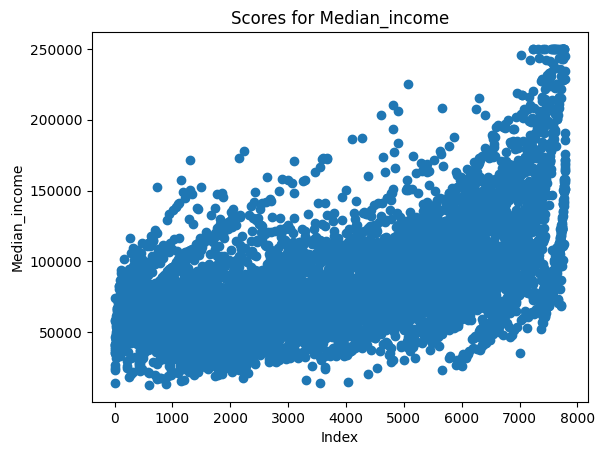

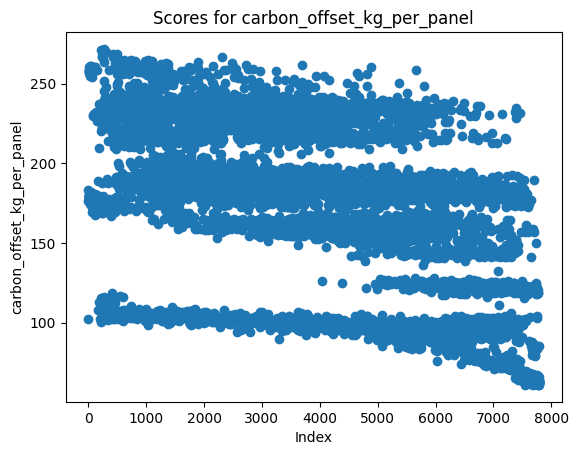

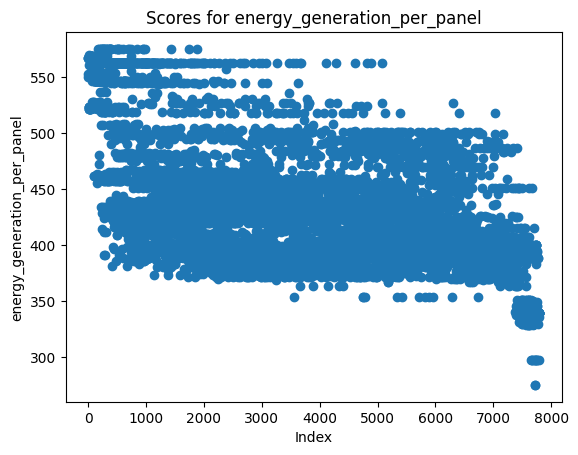

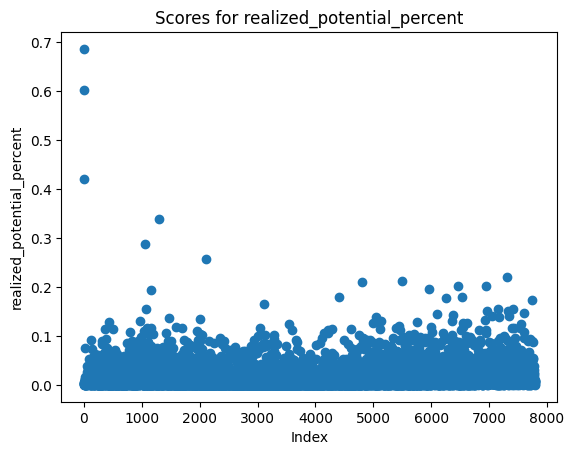

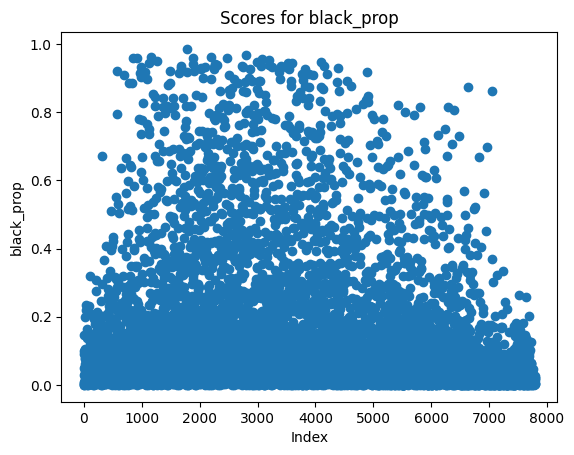

In [5]:

metrics = ['Median_income', 'carbon_offset_kg_per_panel', 'energy_generation_per_panel', 'realized_potential_percent', 'black_prop']

for m in metrics:
    arr = []
    for i in range(len(zip_order)):
        arr.append(combined_df[m][zip_order[i]])
        # arr.append()


    plt.scatter(list(range(len(arr))), arr, marker='o')
    plt.xlabel("Index")
    plt.ylabel(m)
    plt.title(f"Scores for {m}")
    plt.show()

In [6]:
# # Plot best scores per generation
# plt.scatter(list(range(len(fitness_data))), fitness_data, marker='o')
# plt.xlabel("Index")
# plt.ylabel("Score")
# plt.title("Scores for Metric")
# plt.show()

In [7]:
#add the NEAT score for each zip to the df
zip_dict = dict([(index, score[0]) for index, score in zip_outputs])
combined_df['NEAT-Evaluation'] = combined_df.index.map(zip_dict)


In [8]:
#create a heatmap for the zip scores
from plot_util import geo_plot

geo_plot(combined_df['NEAT-Evaluation'], color_scale='agsunset', title="NEAT-Evaluation", edf=combined_df, zipcodes=combined_df, colorbar_label="", size=10)


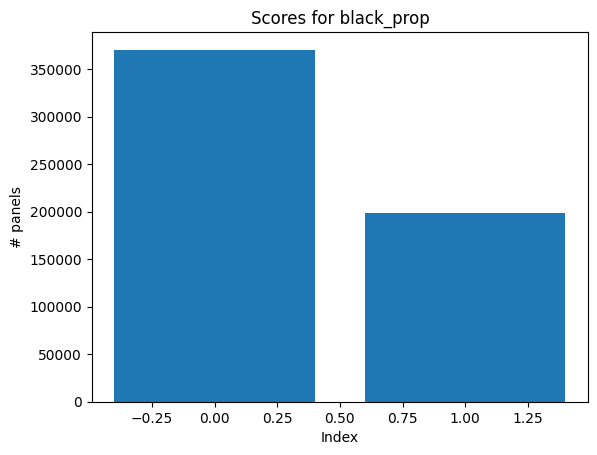

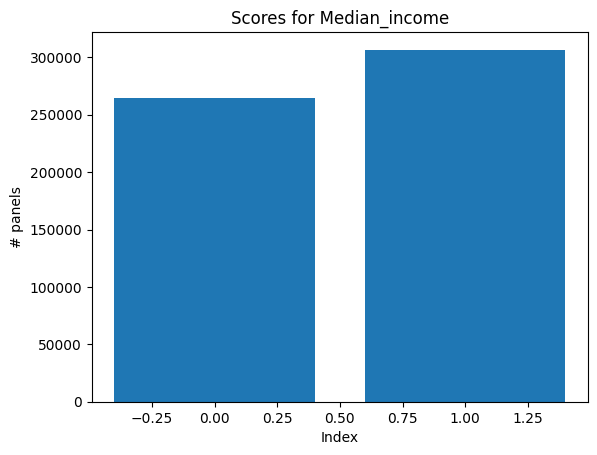

In [9]:
#plot bar buckets

metrics = ['black_prop','Median_income']
k = 2

for m in metrics:
    
    # #alternate way
    q = np.linspace(0, 1, k+1)
    thresholds = data_manager.normalized_df[m].quantile(q).to_numpy()
    buckets, _ = data_manager.greedy_projection_bucket(zip_order, m, n=100000, record=True, thresholds=thresholds)

    #plot buckets
    plt.bar(list(range(k)), buckets)
    plt.xlabel("Index")
    plt.ylabel("# panels")
    plt.title(f"Scores for {m}")
    plt.show()